In [1]:
cd /orange/adamginsburg/jwst/brick/

/orange/adamginsburg/jwst/brick


In [2]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [3]:
from astropy import coordinates

In [4]:
import numpy as np

In [5]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [6]:
import warnings

In [7]:
import regions

In [8]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [9]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [10]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'
pl.rcParams['figure.figsize'] = (10,8)

In [11]:
import glob
from astropy.io import fits

In [12]:
filternames = ['f410m', 'f212n', 'f466n', 'f405n', 'f187n', 'f182m']

In [13]:
#catfns = glob.glob(f"{basepath}/F*/f[0-9][0-9][0-9][nm]*nrca_crowdsource.fits")
catfns = [x
          for filn in filternames
          for x in glob.glob(f"{basepath}/{filn.upper()}/{filn.lower()}*nrca_crowdsource.fits")
         ]
catfns

['/orange/adamginsburg/jwst/brick//F410M/f410m_nrca_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F212N/f212n_nrca_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F466N/f466n_nrca_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F405N/f405n_nrca_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F187N/f187n_nrca_crowdsource.fits',
 '/orange/adamginsburg/jwst/brick//F182M/f182m_nrca_crowdsource.fits']

In [14]:
# jw02221-o001_t001_nircam_f405n-f444w_i2d.fits
# /orange/adamginsburg/jwst/brick//F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits
imgfns = [x
          for filn in filternames
          for x in glob.glob(f"{basepath}/{filn.upper()}/pipeline/jw02221-o001_t001_nircam*{filn.lower()}*nrca*_i2d.fits")
          if 'nrca_' in x or 'nrca1_' in x
         ]

print(" ".join(imgfns))
imgfns

/orange/adamginsburg/jwst/brick//F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits /orange/adamginsburg/jwst/brick//F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca_i2d.fits /orange/adamginsburg/jwst/brick//F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca1_i2d.fits /orange/adamginsburg/jwst/brick//F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits /orange/adamginsburg/jwst/brick//F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits /orange/adamginsburg/jwst/brick//F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca_i2d.fits /orange/adamginsburg/jwst/brick//F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca1_i2d.fits /orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca_i2d.fits /orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca1_i2d.fits


['/orange/adamginsburg/jwst/brick//F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrca1_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F466N/pipeline/jw02221-o001_t001_nircam_clear-f466n-nrca_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F405N/pipeline/jw02221-o001_t001_nircam_clear-f405n-nrca_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-nrca1_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca_i2d.fits',
 '/orange/adamginsburg/jwst/brick//F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrca1_i2d.fits']

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    #wcses = [wcs.WCS(fits.getheader(fn.replace("_crowdsource", "_crowdsource_skymodel"))) for fn in catfns]
    imgs = [fits.getdata(fn, ext=('SCI', 1)) for fn in imgfns]
    wcses = [wcs.WCS(fits.getheader(fn, ext=('SCI', 1))) for fn in imgfns]

In [16]:
# retrieve fixed, updated WCSes
for ii,filn in enumerate(filternames):
    refitpath = f'{basepath}/reduction/headers/{filn.lower()}_nrca_refitted_to_f410m.hdr'
    if os.path.exists(refitpath):
        ww = WCS(fits.Header.fromtextfile(refitpath))
        print(f"Replacing filter {filn} with {refitpath}")
        wcses[ii] = ww

Replacing filter f466n with /orange/adamginsburg/jwst/brick//reduction/headers/f466n_nrca_refitted_to_f410m.hdr
Replacing filter f405n with /orange/adamginsburg/jwst/brick//reduction/headers/f405n_nrca_refitted_to_f410m.hdr


In [17]:
tbls = [Table.read(catfn) for catfn in catfns]
for catfn, tbl in zip(catfns, tbls):
    tbl.meta['filename'] = catfn
    tbl.meta['filter'] = os.path.basename(catfn).split("_")[0]
for tbl, ww in zip(tbls, wcses):
    tbl['y'],tbl['x'] = tbl['x'],tbl['y']
    crds = ww.pixel_to_world(tbl['x'], tbl['y'])
    tbl.add_column(crds, name='skycoords')
    tbl.meta['pixelscale'] = ww.proj_plane_pixel_area()
    flux_jy = (tbl['flux'] * u.MJy/u.sr * (2*np.pi / (8*np.log(2))) * tbl['fwhm']**2 * tbl.meta['pixelscale']).to(u.Jy)
    abmag = flux_jy.to(u.ABmag)
    tbl.add_column(flux_jy, name='flux_jy')
    tbl.add_column(abmag, name='mag_ab')

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: 

In [18]:
basepath = '/orange/adamginsburg/jwst/brick/'
reg = regions.Regions.read(f'{basepath}/regions/leftside_brick_zoom.reg')[0]
regzoom = regions.Regions.read(f'{basepath}/regions/leftside_brick_rezoom.reg')[0]

(266.5349681260688,
 266.54347708116603,
 -28.750867017804357,
 -28.74397384169278)

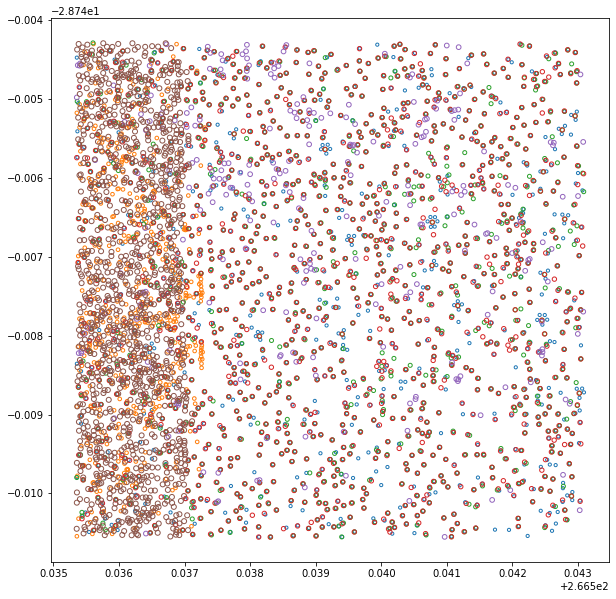

In [19]:
pl.figure(figsize=(10,10))
ax = pl.gca()
for ii, (ww, tbl) in enumerate(zip(wcses, tbls)):
    crds = tbl['skycoords']
    crds = crds[reg.contains(crds, ww)]
    markers = ax.scatter(crds.ra, crds.dec, s=10+3*ii)
    markers.set_edgecolors(markers.get_facecolors())
    markers.set_facecolors('none')
ax.axis()

In [20]:
tbls[0].meta['filter'], len(tbls[0])

('f410m', 73274)

In [21]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    basetable = tbls[0].copy()
    basecrds = basetable['skycoords']
    for colname in basetable.colnames:
        basetable.rename_column(colname, colname+"_"+basetable.meta['filter'])
    #basetable = basetable[[cn for cn in basetable.colnames if not any(x in cn for x in ignored_columns)]]

    for tbl in tbls[1:]:
        wl = tbl.meta['filter']
        print(wl)
        #tbl = tbl[[cn for cn in tbl.colnames if not any(x in cn for x in ignored_columns)]]
        crds = tbl['skycoords']
        matches, sep, _ = basecrds.match_to_catalog_sky(crds, nthneighbor=1)
        basetable.add_column(name=f"sep_{wl}", col=sep)
        basetable.add_column(name=f"id_{wl}", col=matches)
        matchtb = tbl[matches]
        for cn in matchtb.colnames:
            #matchtb[cn][sep > 0.1*u.arcsec].mask = True
            matchtb.rename_column(cn, f"{cn}_{wl}")
        basetable = table.hstack([basetable, matchtb], join_type='exact')
        basetable.meta[f'{wl}_pixelscale'] = tbl.meta['pixelscale']
        #if 'sky_centroid_f444w' in basetable.colnames:
        #    basetable.rename_column('sky_centroid_f444w', 'sky_centroid')
        #basetable = table.join(basetable, tbl,
        #                      table_names=['', wl],
        #                      join_type='outer',
        #                      join_funcs={'sky_centroid': table.join_skycoord(0.1*u.arcsec)})
        #if 'sky_centroid_' in basetable.colnames:
        #    basetable.rename_column('sky_centroid_', 'sky_centroid_f444w')
        basetable.write(f"{basepath}/catalogs/crowdsource_nrca_photometry_tables_merged.ecsv", overwrite=True)
        basetable.write(f"{basepath}/catalogs/crowdsource_nrca_photometry_tables_merged.fits", overwrite=True)

f212n
f466n
f405n
f187n
f182m


In [22]:
# Line-subtract the F410 continuum band
basetable.add_column(basetable['flux_jy_f410m'] - basetable['flux_jy_f405n'] * 0.16, name='flux_jy_410m405')
basetable.add_column(basetable['flux_jy_410m405'].to(u.ABmag), name='mag_ab_410m405')
# Then subtract that remainder back from the F405 band to get the continuum-subtracted F405
basetable.add_column(basetable['flux_jy_f405n'] - basetable['flux_jy_410m405'], name='flux_jy_405m410')
basetable.add_column(basetable['flux_jy_405m410'].to(u.ABmag), name='mag_ab_405m410')

/orange/adamginsburg/miniconda3/envs/python39/lib/python3.9/site-packages/astropy/units/function/logarithmic.py:47: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


0arcsec [0arcsec 0arcsec 0arcsec ... 0arcsec 0arcsec 0arcsec]
0arcsec
-3.81869arcsec [0.078648arcsec 0.244139arcsec 0.143464arcsec ... -0.212244arcsec
 -0.131186arcsec -0.161346arcsec]
-0.77334arcsec
0.00217377arcsec [-0.00124851arcsec 0.222996arcsec -0.132964arcsec ... 0.0214801arcsec
 -0.21219arcsec 0.0233202arcsec]
-0.0142592arcsec
-0.0214583arcsec [-0.0728921arcsec 0.209342arcsec -0.0601079arcsec ... -0.207803arcsec
 -0.0161035arcsec -0.0150098arcsec]
-0.0163868arcsec
0.0145277arcsec [0.0304233arcsec 0.161138arcsec -0.0473175arcsec ... -0.0878231arcsec
 0.064447arcsec 0.232435arcsec]
0.00251545arcsec
-1.33252arcsec [0.14013arcsec 0.0186448arcsec 0.0493073arcsec ... -0.0588879arcsec
 -0.231371arcsec -0.150447arcsec]
-0.700165arcsec


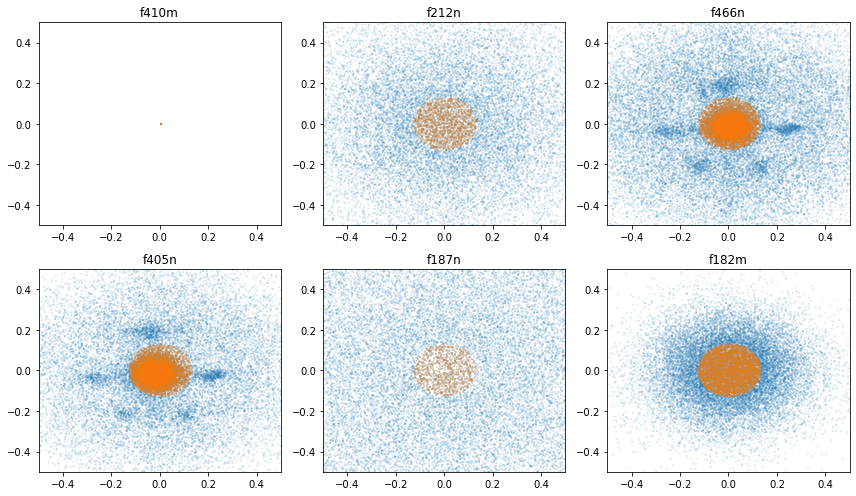

In [23]:
pl.figure(figsize=(12,7))
basecrds = basetable['skycoords_f410m']
ii = 1
for tbl in tbls:
    ax = pl.subplot(2,3,ii)
    filtername = tbl.meta['filter']
    #print(ii, filtername)
    crds = basetable[f'skycoords_{filtername}']
    radiff = (crds.ra-basecrds.ra).to(u.arcsec)
    decdiff = (crds.dec-basecrds.dec).to(u.arcsec)
    print(np.median(radiff), radiff[np.abs(radiff) < 0.25*u.arcsec])
    print(np.median(decdiff))
    ok = (radiff**2 + decdiff**2) < (0.13*u.arcsec)**2
    ax.scatter(radiff, decdiff, marker=',', s=1, alpha=0.1)
    ax.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.1)
    ax.axis([-0.5, 0.5, -0.5, 0.5])
    ax.set_title(filtername)
    ii += 1
pl.tight_layout()

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    basetable = Table.read(f"{basepath}/catalogs/crowdsource_nrca_photometry_tables_merged.ecsv")
    
    basecrds = basetable['skycoords_f410m']
    for tbl in tbls[1:]:
        wl = tbl.meta['filter']
        crds = basetable[f'skycoords_{wl}']
        radiff = (crds.ra-basecrds.ra).to(u.arcsec)
        decdiff = (crds.dec-basecrds.dec).to(u.arcsec)
        oksep = basetable[f'sep_{wl}'] < 0.25*u.arcsec
        medsep_ra, medsep_dec = np.median(radiff[oksep]), np.median(decdiff[oksep])
        print(wl, medsep_ra, medsep_dec)
        newcrds = SkyCoord(crds.ra - medsep_ra, crds.dec - medsep_dec, frame=crds.frame)
        basetable[f'skycoords_{wl}'] = newcrds
        matches, sep, _ = basecrds.match_to_catalog_sky(newcrds, nthneighbor=1)
        basetable[f"sep_{wl}"] = sep
        basetable[f"id_{wl}"] = matches
        basetable.write(f"{basepath}/catalogs/crowdsource_nrca_photometry_tables_merged_offsetcorrected.ecsv", overwrite=True)
        basetable.write(f"{basepath}/catalogs/crowdsource_nrca_photometry_tables_merged_offsetcorrected.fits", overwrite=True)

f212n -0.00402181arcsec -0.00413904arcsec
f466n 0.00218781arcsec -0.0143506arcsec
f405n -0.0215425arcsec -0.0164036arcsec
f187n -0.00145434arcsec -0.00479053arcsec


In [ ]:
pl.figure(figsize=(12,7))
basecrds = basetable['skycoords_f410m']
ii = 1
for tbl in tbls[1:]:
    ax = pl.subplot(2,3,ii)
    filtername = tbl.meta['filter']
    #print(ii, filtername)
    crds = basetable[f'skycoords_{filtername}']
    radiff = (crds.ra-basecrds.ra).to(u.arcsec)
    decdiff = (crds.dec-basecrds.dec).to(u.arcsec)
    #print(np.median(radiff), radiff[np.abs(radiff) < 0.25*u.arcsec])
    #print(np.median(decdiff))
    sep = basetable[f'sep_{filtername}']
    print(filtername, np.median(sep.to(u.arcsec)), np.median(sep[sep<0.13*u.arcsec].to(u.arcsec)))
    ok = sep < (0.13*u.arcsec)
    ax.scatter(radiff, decdiff, marker=',', s=1, alpha=0.1)
    ax.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.1)
    ax.axis([-0.5, 0.5, -0.5, 0.5])
    ax.set_title(filtername)
    ii += 1
pl.tight_layout()

In [ ]:
len(basetable)

In [ ]:
basetable[reg.contains(basetable['skycoords_f405n'],ww)][:5]

In [ ]:
basetable[reg.contains(basetable['skycoords_f410m'],ww)][:5]['flux_f410m', 'skycoords_f410m', 'x_f410m', 'y_f410m']

In [ ]:
#(500*u.Jy).to(u.ABmag)
(basetable[reg.contains(basetable['skycoords_f410m'],ww)][:5]['flux_f410m'] * u.Jy).to(u.ABmag)

In [ ]:
tbls[5][20:30]

In [ ]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['flux'], bins=np.logspace(0,7), log=True)
    ax.set_title(tbl.meta['filter'])
    ax.loglog()
pl.tight_layout()

In [ ]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['flux_jy'], log=True)
    ax.set_title(tbl.meta['filter'])
    ax.loglog()
pl.tight_layout()

In [ ]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['mag_ab'], log=True)
    ax.set_title(tbl.meta['filter'])
    #ax.loglog()
pl.tight_layout()

In [ ]:
for ii, tbl in enumerate(tbls):
    ax = pl.subplot(2,3,ii+1)
    ax.hist(tbl['fwhm'], log=True)
    ax.set_title(tbl.meta['filter'])
pl.tight_layout()

# XMatch Check

In [ ]:
len(tbls[0]), tbls[0].meta['filter']

In [ ]:
fh = fits.open(f'{basepath}/F410M/pipeline/jw02221-o001_t001_nircam_clear-f410m-nrca_i2d.fits')
ww410 = wcs.WCS(fh[1].header)

In [ ]:
pl.figure(figsize=(10,10))
ax = pl.subplot(projection=ww410)
data410 = imgs[0]
ax.imshow(data410)
for tbl,marker in zip(tbls, 'osx+v*'):
    crds = tbl['skycoords']
    pl.scatter(crds.ra, crds.dec, alpha=0.75, s=35,
               marker=marker, label=tbl.meta['filter'])
pl.axis((266.5385, 266.54, -28.740, -28.7385))
pl.legend(loc='best')

# Color-magnitude and color-color diagrams

In [ ]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f405n")
pl.ylabel("f410m")
pl.ylim(25,13)

pl.figure()
pl.scatter(basetable['mag_ab_410m405'] - basetable['mag_ab_f405n'], basetable['mag_ab_410m405'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_410m405'] - basetable['mag_ab_f405n'])[sel], basetable['mag_ab_410m405'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f405n")
pl.ylabel("f410m")
pl.ylim(25,13)

In [ ]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f466n")
pl.ylabel("f410m")
pl.ylim(25,14)

In [ ]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
sel2 = regzoom.contains(basetable['skycoords_f410m'], ww)
sel2 &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel2 &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m']-basetable['mag_ab_f405n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel], s=5, alpha=0.5, c='r')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel2], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel2], s=5, alpha=0.5, c='g')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f466n")
pl.ylabel("f410m - f405n")
pl.axis((-5,10,-5,10))

In [ ]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
sel2 = regzoom.contains(basetable['skycoords_f410m'], ww)
sel2 &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel2 &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
#pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m']-basetable['mag_ab_f405n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel], s=5, alpha=0.5, c='r')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel2], (basetable['mag_ab_f410m']-basetable['mag_ab_f405n'])[sel2], s=5, alpha=0.5, c='g')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m - f466n")
pl.ylabel("f410m - f405n")
pl.axis((-5,10,-5,10))

In [ ]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
sel2 = regzoom.contains(basetable['skycoords_f410m'], ww)
sel2 &= basetable['sep_f466n'].quantity < 0.1*u.arcsec
sel2 &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'], basetable['mag_ab_410m405']-basetable['mag_ab_f405n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'])[sel], (basetable['mag_ab_410m405']-basetable['mag_ab_f405n'])[sel], s=5, alpha=0.5, c='r')
pl.scatter((basetable['mag_ab_410m405'] - basetable['mag_ab_f466n'])[sel2], (basetable['mag_ab_410m405']-basetable['mag_ab_f405n'])[sel2], s=5, alpha=0.5, c='g')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f410m linesub - f466n")
pl.ylabel("f410m linesub - f405n")
pl.axis((-5,10,-5,10))

In [ ]:
sel = reg.contains(basetable['skycoords_f410m'], ww)
sel &= basetable['sep_f182m'].quantity < 0.1*u.arcsec
pl.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f182m'], basetable['mag_ab_f410m'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f182m'])[sel], basetable['mag_ab_f410m'][sel], s=5, alpha=0.5, c='r')
pl.xlabel("f410m - f182m")
pl.ylabel("f410m")
pl.ylim(25,14)

In [ ]:
sel = reg.contains(basetable['skycoords_f212n'], ww)
pl.scatter(basetable['mag_ab_f212n'] - basetable['mag_ab_f182m'], basetable['mag_ab_f212n'], s=5, alpha=0.5, c='k')
pl.scatter((basetable['mag_ab_f212n'] - basetable['mag_ab_f182m'])[sel], basetable['mag_ab_f212n'][sel], s=5, alpha=0.5, c='r')
pl.ylim(pl.ylim()[::-1])
pl.xlabel("f212n - f182m")
pl.ylabel("f212n")
pl.ylim(25,14)

In [ ]:
pl.figure(figsize=(12,7))
basecrds = basetable['skycoords_f410m']
ii = 1
for tbl in tbls:
    ax = pl.subplot(2,3,ii)
    filtername = tbl.meta['filter']
    #print(ii, filtername)
    crds = basetable[f'skycoords_{filtername}']
    radiff = (crds.ra-basecrds.ra).to(u.arcsec)
    decdiff = (crds.dec-basecrds.dec).to(u.arcsec)
    print(np.median(radiff), radiff[np.abs(radiff) < 0.25*u.arcsec])
    print(np.median(decdiff))
    ok = (radiff**2 + decdiff**2) < (0.13*u.arcsec)**2
    ax.scatter(radiff, decdiff, marker=',', s=1, alpha=0.1)
    ax.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.1)
    ax.axis([-0.5, 0.5, -0.5, 0.5])
    ax.set_title(filtername)
    ii += 1
pl.tight_layout()

In [ ]:
import PIL
import pyavm

In [ ]:
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_longwave_RGB_unrotated.png')
img = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_longwave_RGB_unrotated.png'))[::-1,:,:]
#wwi = avm.to_wcs(use_full_header=True)
wwi = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

In [ ]:
# This image shows "CO-absorbed" stars as purple
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_nrca_longwave_stars_rotated.png')
img = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_nrca_longwave_stars_rotated.png'))[::-1,:,:]
#wwi = avm.to_wcs(use_full_header=True)
wwi = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

In [ ]:
wwi

In [ ]:
ax = pl.subplot(projection=wwi)
ax.imshow(img)
crds = basetable['skycoords_f410m']
ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('fk5'), marker=',', s=1)

In [ ]:
reg

In [ ]:
mask = reg.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
#co = np.array([mask.cutout(img[:,:,ii]) for ii in range(img.shape[2])])
co = img[slcs[0], slcs[1], :]

pl.figure(figsize=(10,10))
ax = pl.subplot(projection=wwi[slcs])
pl.imshow(co)

crds = basetable['skycoords_f410m']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
#sel = sel & (colorby > 2)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  edgecolor='y', facecolor='none', marker='s',
                  alpha=0.5)#r'$\rightarrow$')
                  #c=colorby[sel],
                  #norm=simple_norm(colorby[sel], stretch='linear',), cmap='jet')
#pl.draw()
#colors = scat.get_facecolors()
#scat.set_edgecolors(colors)
#scat.set_facecolors('none')

In [ ]:
mask = regzoom.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
#co = np.array([mask.cutout(img[:,:,ii]) for ii in range(img.shape[2])])
co = img[slcs[0], slcs[1], :]

pl.figure(figsize=(20,10))
ax = pl.subplot(1,2,1, projection=wwi[slcs])
pl.imshow(co)

crds = basetable['skycoords_f410m']
sel = regzoom.contains(crds, ww410)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f466n']
#sel = sel & (colorby < -2)

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  #edgecolor='r', facecolor='none', marker='s')#r'$\rightarrow$')
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')
#pl.colorbar(mappable=scat)
ax.axis()
pl.plot(44,54, 'wx')
wwi[slcs].pixel_to_world(45,55)

ax2 = pl.subplot(1,2,2)
ax2.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m'], s=2, alpha=0.05, c='k')
ax2.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f410m'][sel], s=10, alpha=0.9,
            c=colorby[sel],
            norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r'
           )
ax2.axvline(-0.75, linestyle='--', color='r', alpha=0.5)
ax2.axvline(-1.25, linestyle='--', color='r', alpha=0.5)
ax2.set_ylim(pl.ylim()[::-1])
ax2.set_xlabel("f410m - f466n")
ax2.set_ylabel("f410m")
ax2.set_ylim(25,14)

In [ ]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_nrca_longwave_stars_bra_410.png')
img_bra_410 = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_nrca_longwave_stars_bra_410.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_bra_410 = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))

mask = regzoom.to_pixel(wwi_bra_410).to_mask()
slcs,_ = mask.get_overlap_slices(img_bra_410.shape[:2])
#co = np.array([mask.cutout(img_bra_410[:,:,ii]) for ii in range(img_bra_410.shape[2])])
co = img_bra_410[slcs[0], slcs[1], :]

pl.figure(figsize=(20,10))
ax = pl.subplot(1,2,1, projection=wwi_bra_410[slcs])
pl.imshow(co)

crds = basetable['skycoords_f410m']
sel = regzoom.contains(crds, ww410)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
#sel = sel & (colorby < -2)

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  #edgecolor='r', facecolor='none', marker='s')#r'$\rightarrow$')
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')
#pl.colorbar(mappable=scat)
ax.axis()
pl.plot(44,54, 'wx')
wwi_bra_410[slcs].pixel_to_world(45,55)

ax2 = pl.subplot(1,2,2)
ax2.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'], basetable['mag_ab_f410m'], s=2, alpha=0.05, c='k')
ax2.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f405n'])[sel], basetable['mag_ab_f410m'][sel], s=10, alpha=0.9,
            c=colorby[sel],
            norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r'
           )
ax2.axvline(-0.75, linestyle='--', color='r', alpha=0.5)
ax2.axvline(-1.25, linestyle='--', color='r', alpha=0.5)
ax2.set_ylim(pl.ylim()[::-1])
ax2.set_xlabel("f410m - f405")
ax2.set_ylabel("f410m")
ax2.set_ylim(25,14)

In [ ]:
blue_410_466 = (basetable['mag_ab_f410m'] - basetable['mag_ab_f466n']) < -1.25
pl.scatter(crds.ra[blue_410_466], crds.dec[blue_410_466])
blue_410_405 = (basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']) < -1.00
pl.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none')

In [ ]:
import warnings

In [ ]:
def starzoom(coords):
    reg = regions.RectangleSkyRegion(center=coords, width=1*u.arcsec, height=1*u.arcsec)
    ii = 0
    pl.figure(figsize=(12,4))
    filters_plotted = []
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        for fn in sorted(glob.glob(f'{basepath}/F*/pipeline/*nircam*nrc*_i2d.fits')):
            filtername = fits.getheader(fn)['PUPIL']+fits.getheader(fn)['FILTER']
            if filtername in filters_plotted:
                continue
            ww = wcs.WCS(fits.getheader(fn, ext=('SCI',1)))
            if ww.footprint_contains(coords):
                print(fn)
                data = fits.getdata(fn, ext=('SCI',1))
                mask = reg.to_pixel(ww).to_mask()
                slcs,_ = mask.get_overlap_slices(data.shape)
                ax = pl.subplot(1,6,ii+1)
                ax.imshow(data[slcs], norm=simple_norm(data[slcs], stretch='asinh'),
                          origin='lower', cmap='gray')
                xx, yy = ww[slcs].world_to_pixel(coords)
                ax.plot(xx, yy, 'rx')
                ax.set_title(filtername)
                filters_plotted.append(filtername)
                ii += 1

In [ ]:
starzoom(coordinates.SkyCoord(266.54177, -28.74910, unit=(u.deg, u.deg), frame='icrs'))

In [ ]:
starzoom(coordinates.SkyCoord("17:46:10.006 -28:44:21.00", unit=(u.hour, u.deg), frame='icrs'))

In [ ]:
starzoom(coordinates.SkyCoord("17:46:10.682 -28:42:23.87", unit=(u.hour, u.deg), frame='icrs'))

In [ ]:
starzoom(coordinates.SkyCoord("17:46:09.310 -28:44:08.95", unit=(u.hour, u.deg), frame='icrs'))

In [ ]:
starzoom(coordinates.SkyCoord("17:46:09.256 -28:44:11.15", unit=(u.hour, u.deg), frame='icrs'))

In [ ]:
starzoom(coordinates.SkyCoord("17:46:03.833 -28:42:59.76", unit=(u.hour, u.deg), frame='icrs'))

In [ ]:
starzoom(coordinates.SkyCoord("17:46:07.378 -28:45:29.38", unit=(u.hour, u.deg), frame='icrs'))

In [ ]:
ww410

In [ ]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410[slcs])
co = mask.cutout(fh['SCI'].data)
co = fh['SCI'].data[slcs]
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='linear',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=0.1 * u.arcsec)
lat.set_ticks(spacing=0.1 * u.arcsec)

In [ ]:
tbls[0].meta

In [ ]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410)
#ax = pl.gca()
co = fh['SCI'].data
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
#crds = tbls[0]['skycoords']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])
#scat = ax.scatter(xx, yy, c=basetable['flux_f410m'][sel],
#                  norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'), c=basetable['flux_f410m'][sel],
           norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=1 * u.arcsec)
lat.set_ticks(spacing=1 * u.arcsec)

In [ ]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410)
#ax = pl.gca()
co = fh['SCI'].data
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
#crds = tbls[0]['skycoords']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])
#scat = ax.scatter(xx, yy, c=basetable['flux_f410m'][sel],
#                  norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'), c=basetable['flux_f410m'][sel],
           norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=1 * u.arcsec)
lat.set_ticks(spacing=1 * u.arcsec)
ax.axis((676,1043,1119,1515))

In [ ]:
pl.figure(figsize=(12,12))
mask = reg.to_pixel(ww410).to_mask()
slcs,_ = mask.get_overlap_slices(fh['SCI'].data.shape)
ax = pl.subplot(projection=ww410)
#ax = pl.gca()
co = fh['SCI'].data
ax.imshow(co, cmap='gray', norm=simple_norm(co, stretch='log', max_percent=99.95), origin='lower')
crds = basetable['skycoords_f410m']
#crds = tbls[0]['skycoords']
sel = reg.contains(crds, ww410)
xx,yy = ww410[slcs].world_to_pixel(crds[sel])
##scat = ax.scatter(xx, yy, c=basetable['flux_f410m'][sel],
##                  norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
#scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'), c=basetable['flux_f410m'][sel],
#           norm=simple_norm(basetable['flux_f410m'][sel], stretch='log',), cmap='jet')
#pl.draw()
#colors = scat.get_facecolors()
#scat.set_edgecolors(colors)
#scat.set_facecolors('none')

blue_410_466 = (basetable['mag_ab_f410m'] - basetable['mag_ab_f466n']) < -1.25
pl.scatter(crds.ra[blue_410_466], crds.dec[blue_410_466], transform=ax.get_transform('world'))
blue_410_405 = (basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']) < -1.00
pl.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))

lon = ax.coords[0]
lat = ax.coords[1]
lon.set_major_formatter('dd:mm:ss.sss')
lat.set_major_formatter('dd:mm:ss.sss')
lon.set_ticks(spacing=1 * u.arcsec)
lat.set_ticks(spacing=1 * u.arcsec)

In [ ]:
# This image shows only H-alpha stars
avm = pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated_lighter.png')
img_narrow = np.array(PIL.Image.open(f'{basepath}/images/BrickJWST_nrca_longwave_narrowband_rotated_lighter.png'))[::-1,:,:]
#wwi_bra_410 = avm.to_wcs(use_full_header=True)
wwi_narrow = wcs.WCS(fits.Header.fromstring(avm.Spatial.FITSheader))


pl.figure(figsize=(12,12))
ax = pl.subplot(projection=wwi_narrow)
ax.imshow(img_narrow)

crds = basetable['skycoords_f410m']
blue_410_466 = (basetable['mag_ab_410m405'] - basetable['mag_ab_f466n']) < -1.75
ax.scatter(crds.ra[blue_410_466], crds.dec[blue_410_466], transform=ax.get_transform('world'), edgecolors=(0.3, 0.5, 0.8), facecolors='none')
blue_410_405 = (basetable['mag_ab_410m405'] - basetable['mag_ab_f405n']) < -1.25
ax.scatter(crds.ra[blue_410_405], crds.dec[blue_410_405], edgecolors='orange', facecolors='none', transform=ax.get_transform('world'))



In [ ]:
mask = regzoom.to_pixel(wwi).to_mask()
slcs,_ = mask.get_overlap_slices(img.shape[:2])
#co = np.array([mask.cutout(img[:,:,ii]) for ii in range(img.shape[2])])
co = img[slcs[0], slcs[1], :]

pl.figure(figsize=(20,10))
ax = pl.subplot(1,2,1, projection=wwi[slcs])
pl.imshow(co)

crds = basetable['skycoords_f410m']
sel = regzoom.contains(crds, ww410)
sel &= basetable['sep_f405n'].quantity < 0.1*u.arcsec
xx,yy = ww410[slcs].world_to_pixel(crds[sel])

colorby = basetable['flux_f410m']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f405n']
colorby = basetable['mag_ab_f410m'] - basetable['mag_ab_f466n']
#sel = sel & (colorby < -2)

scat = ax.scatter(crds.ra[sel], crds.dec[sel], transform=ax.get_transform('world'),
                  #edgecolor='r', facecolor='none', marker='s')#r'$\rightarrow$')
                  c=colorby[sel],
                  norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r')
pl.draw()
colors = scat.get_facecolors()
scat.set_edgecolors(colors)
scat.set_facecolors('none')
#pl.colorbar(mappable=scat)
axlims = ax.axis()
pl.plot(44,54, 'wx')
wwi[slcs].pixel_to_world(45,55)

# show the maximum detections
sel2 = regzoom.contains(tbls[0]['skycoords'], ww410)
ax.scatter(tbls[0]['skycoords'].ra[sel2], tbls[0]['skycoords'].dec[sel2], marker='x', color='w', transform=ax.get_transform('world'))
ax.axis(axlims)

ax2 = pl.subplot(1,2,2)
ax2.scatter(basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'], basetable['mag_ab_f410m'], s=2, alpha=0.05, c='k')
ax2.scatter((basetable['mag_ab_f410m'] - basetable['mag_ab_f466n'])[sel], basetable['mag_ab_f410m'][sel], s=10, alpha=0.9,
            c=colorby[sel],
            norm=simple_norm(colorby[sel], stretch='asinh',), cmap='jet_r'
           )
ax2.axvline(-0.75, linestyle='--', color='r', alpha=0.5)
ax2.axvline(-1.25, linestyle='--', color='r', alpha=0.5)
ax2.set_ylim(pl.ylim()[::-1])
ax2.set_xlabel("f410m - f466n")
ax2.set_ylabel("f410m")
ax2.set_ylim(25,14)

In [ ]:
pl.scatter(tbls[0]['skycoords'].ra[sel2], tbls[0]['skycoords'].dec[sel2], marker='x', color='r')